In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd

In [3]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [6]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [8]:
df_train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [9]:
df_train = df_train.sort_values(by=['store_nbr', 'family', 'date'])

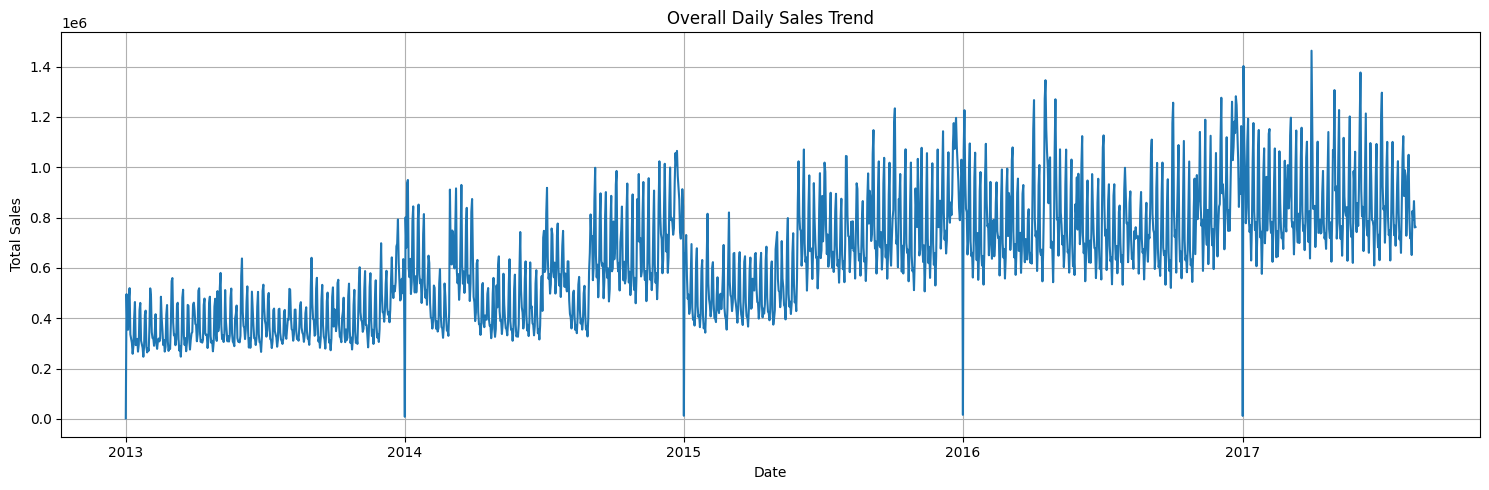

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Aggregate daily total sales across all stores and families
daily_sales = df_train.groupby('date')['sales'].sum()

# Plot the overall sales trend
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

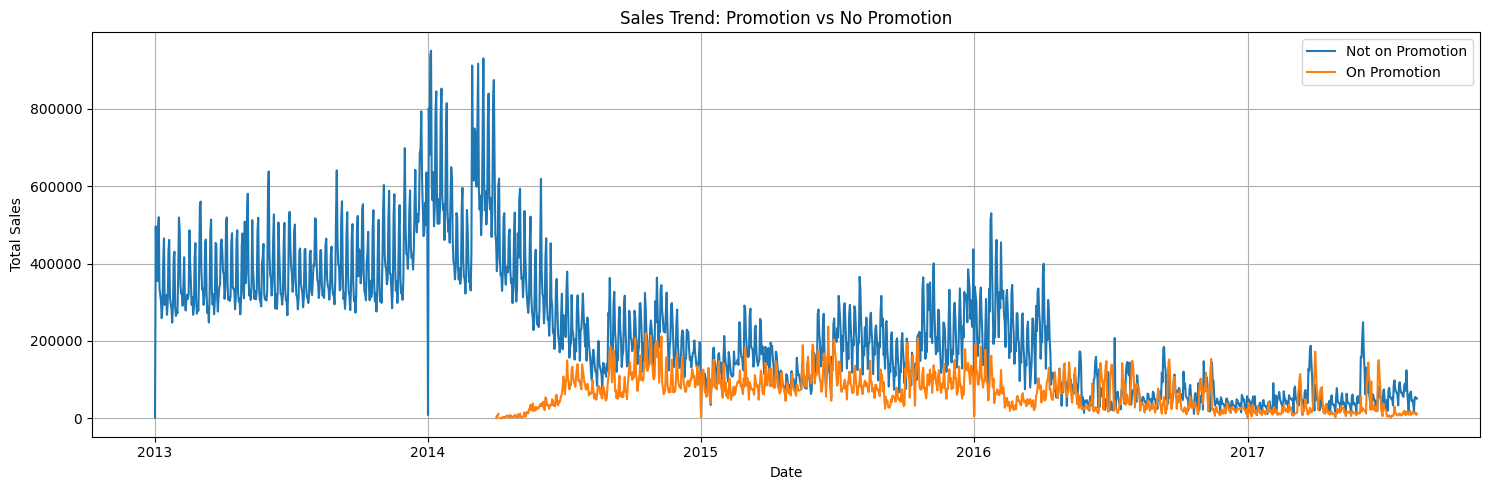

In [11]:
# Group by date and promotion status, then calculate total sales
promo_impact = df_train.groupby(['date', 'onpromotion'])['sales'].sum().unstack()

# Plot sales for promoted vs. non-promoted items
plt.figure(figsize=(15, 5))
plt.plot(promo_impact.index, promo_impact[0], label='Not on Promotion')
plt.plot(promo_impact.index, promo_impact[1], label='On Promotion')
plt.title('Sales Trend: Promotion vs No Promotion')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

In [13]:
df_train = df_train.merge(df_stores, on='store_nbr', how='left', suffixes=('', '_drop'))
df_train = df_train[[col for col in df_train.columns if not col.endswith('_drop')]]
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


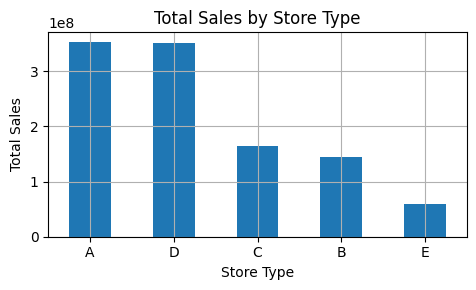

In [14]:
# Total sales by store type
sales_by_type = df_train.groupby('type')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sales_by_type.plot(kind='bar')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(True)
plt.show()


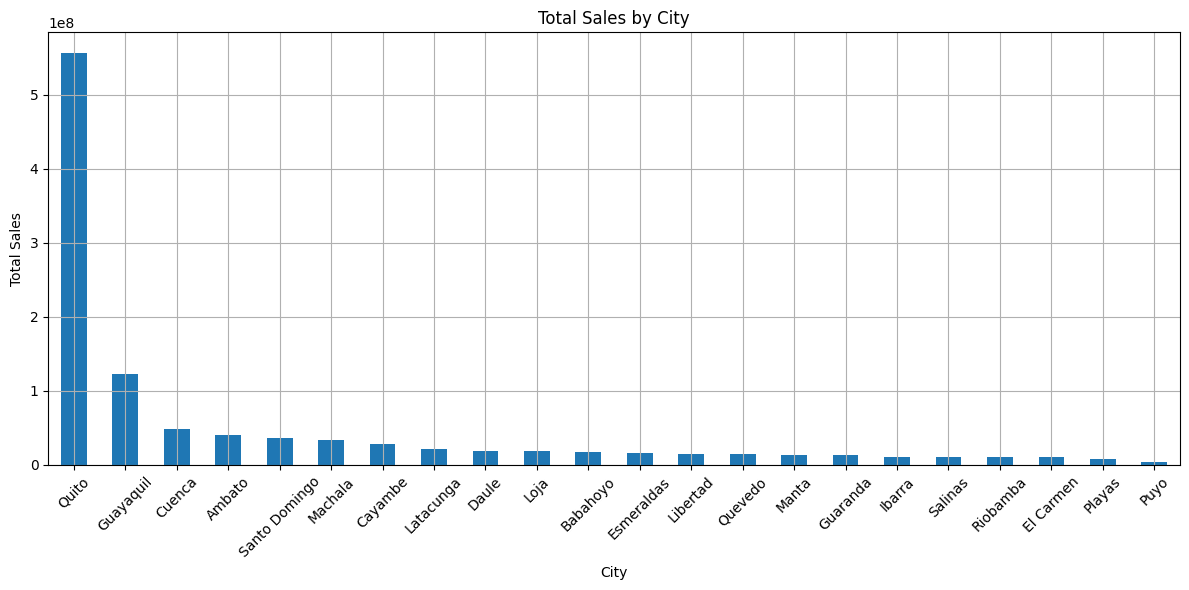

In [15]:
# Total sales by city
sales_by_city = df_train.groupby('city')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_city.plot(kind='bar')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()